In [62]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier

In [63]:
train_data = train_data = pd.read_csv('data/preprocessed_dataset.csv')

train_data['increase_stock'] = np.where(train_data['increase_stock'] == 'low_bike_demand', 0, 1)

X = train_data.drop('increase_stock', axis=1)
y = train_data['increase_stock']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

xgb_model = xgb.XGBClassifier(random_state=0)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)


print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f'Confusion Matrix: \n{conf_matrix}')

Accuracy: 0.87
Precision: 0.65
Recall: 0.60
F1-Score: 0.62
Confusion Matrix: 
[[243  19]
 [ 23  35]]


In [64]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2, 0.3,0.4],
    'n_estimators': [0, 25, 50, 100],
}

grid_search = GridSearchCV(
    estimator=XGBClassifier(random_state=0),
    param_grid=param_grid,
    scoring='recall',  # RECALL OR ????
    cv=3,  # 3fold
    verbose=1
)

grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best recall:", grid_search.best_score_)


Fitting 3 folds for each of 60 candidates, totalling 180 fits
Best parameters: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 25}
Best recall: 0.6955456823877877


In [65]:
from sklearn.model_selection import cross_val_score

final_model = xgb.XGBClassifier(**grid_search.best_params_, random_state=42)
scores = cross_val_score(final_model, X_train, y_train, cv=5, scoring='recall')
print(f"Cross-Validation recall: {scores.mean():.2f} ± {scores.std():.2f}")

Cross-Validation recall: 0.70 ± 0.06


In [66]:
final_model.fit(X_train, y_train)
y_test_pred = final_model.predict(X_test)
print(f"Test Set recall: {recall_score(y_test, y_test_pred):.2f}")

Test Set recall: 0.55


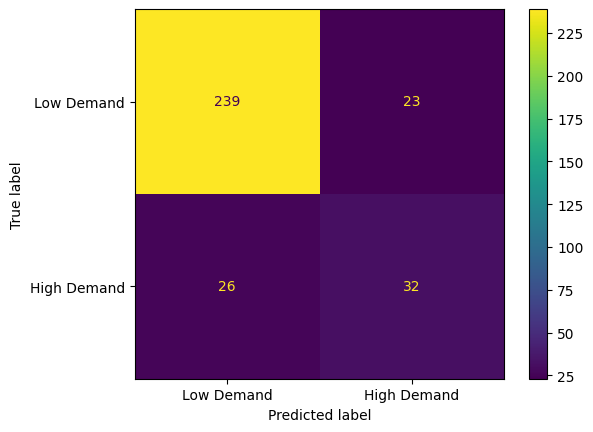

In [67]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low Demand', 'High Demand'])
disp.plot()

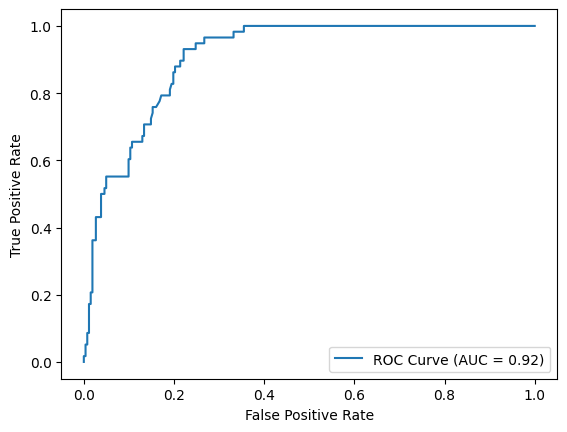

In [74]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

y_prob = final_model.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
